In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np

## Gathering the data


In [2]:
# Legacy Pagecounts API
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

# Pageviews API
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

### 1. Get desktop and mobile traffic data from December 2007 through July 2016 from the Legacy Pagecounts API.

### 2. Get desktop, mobile web, and mobile app traffic data from July 2015 through last month from the Pageviews API.

In [3]:
legacy_desktop = example_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }

legacy_mobile = example_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }
                    
pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020091000'
                        }

pageviews_app = {"project" : "en.wikipedia.org",
                "access" : "mobile-app",
                "agent" : "user",
                "granularity" : "monthly",
                "start" : "2015070100",
                # for end use 1st day of month following final month of data
                "end" : '2020091000'
                    }

pageviews_web = {"project" : "en.wikipedia.org",
                "access" : "mobile-web",
                "agent" : "user",
                "granularity" : "monthly",
                "start" : "2015070100",
                # for end use 1st day of month following final month of data
                "end" : '2020091000'
                    }

headers = {'User-Agent': 'https://github.com/qye25',
        'From': 'qye25@uw.edu'
}

In [4]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
def saveJSON(filename, endpoint, parameters):
    response = api_call(endpoint,parameters)
    with open(filename+".json", 'w') as json_file:
        json.dump(response, json_file)

### 3. Save complete and un-edited output of API queries to json files

In [6]:
saveJSON("pagecounts_desktop-site_200712-201607",endpoint_legacy, legacy_desktop)
saveJSON("pagecounts_mobile-site_200712-201607",endpoint_legacy, legacy_mobile)

saveJSON("pageviews_desktop_201507-202009",endpoint_pageviews, pageviews_desktop)
saveJSON("pageviews_mobile-app_201507-202009",endpoint_pageviews, pageviews_app)
saveJSON("pageviews_mobile-web_201507-202009",endpoint_pageviews, pageviews_web)

## Data Processing

###  1. Convert json files to dataframes

In [7]:
# data = json.loads("pagecounts_desktop-site_200712-201607.json")
with open('pagecounts_desktop-site_200712-201607.json') as f:
  data = json.load(f)
pagecounts_desktop_site = pd.DataFrame(data['items'])

with open('pagecounts_mobile-site_200712-201607.json') as f:
  data = json.load(f)
pagecounts_mobile_site = pd.DataFrame(data['items'])

with open('pageviews_desktop_201507-202009.json') as f:
  data = json.load(f)
pageviews_desktop = pd.DataFrame(data['items'])

with open('pageviews_mobile-app_201507-202009.json') as f:
  data = json.load(f)
pageviews_mobile_app = pd.DataFrame(data['items'])

with open('pageviews_mobile-web_201507-202009.json') as f:
  data = json.load(f)
pageviews_mobile_web = pd.DataFrame(data['items'])

### 2. For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

In [8]:
for table in [pagecounts_desktop_site, pagecounts_mobile_site, pageviews_desktop, pageviews_mobile_app, pageviews_mobile_web]:
    table['year'] = table['timestamp'].apply(lambda x : x[:4])
    table['month'] = table['timestamp'].apply(lambda x : x[4:6])

### 3. Merge all tables on date

In [9]:
df = pagecounts_desktop_site[['year','month','count']]
df = df.merge(pagecounts_mobile_site[['year','month','count']], on=('year', 'month'), how = 'outer', suffixes=('_pagecount_desktop_views', '_pagecount_mobile_views'))

df = df.merge(pageviews_desktop[['year','month','views']], on=('year', 'month'), how = 'outer')

df = df.merge(pageviews_mobile_app[['year','month','views']], on=('year', 'month'), how = 'outer')

df = df.merge(pageviews_mobile_web[['year','month','views']], on=('year', 'month'), how = 'outer')

df.columns = ['year','month','pagecount_desktop_views', 'pagecount_mobile_views' , 'pageviews_desktop_views', 'pageviews_mobile_app', 'pageviews_mobile_web']

In [10]:
df

,year,month,pagecount_desktop_views,pagecount_mobile_views,pageviews_desktop_views,pageviews_mobile_app,pageviews_mobile_web
0,2007,12,2.998332e+09,NaN,NaN,NaN,NaN
1,2008,01,4.930903e+09,NaN,NaN,NaN,NaN
2,2008,02,4.818394e+09,NaN,NaN,NaN,NaN
3,2008,03,4.955406e+09,NaN,NaN,NaN,NaN
4,2008,04,5.159162e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
148,2020,04,NaN,NaN,3.798373e+09,172919648.0,5.332822e+09
149,2020,05,NaN,NaN,3.078094e+09,142644741.0,5.089055e+09
150,2020,06,NaN,NaN,2.721329e+09,21933093.0,4.552042e+09
151,2020,07,NaN,NaN,2.638936e+09,134547886.0,4.675167e+09


### 4. For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month. 

In [11]:
df = df.fillna(0)

df['pageviews_mobile_views'] = df['pageviews_mobile_app']+df['pageviews_mobile_web']
df = df.drop(columns=['pageviews_mobile_app', 'pageviews_mobile_web'])

### 5. Combine monthly values for mobile and desktop views to create a total traffic count for data from both APIs.

In [12]:
df['pagecount_all_views'] = df['pagecount_desktop_views'] + df['pagecount_mobile_views']

df['pageview_all_views'] = df['pageviews_mobile_views'] + df['pageviews_desktop_views']

### 6. Replace N/A with 0 for all months with no pageviews and save as a csv file. 

In [13]:
df.to_csv('en-wikipedia_traffic_200712-201809.csv', index = False, na_rep = 0)

## Visualize Data

### 1. Set (year, month) pair as index

In [14]:
df = df.replace(0, np.nan)

df.set_index(pd.to_datetime({
    'day': 1,
    'month': df['month'],
    'year': df['year']
}), inplace=True)
# df.Value.plot()
# plt.plot_date( df['year'], df['pageview_all_views'])

### 2. Plot and save as a .png image

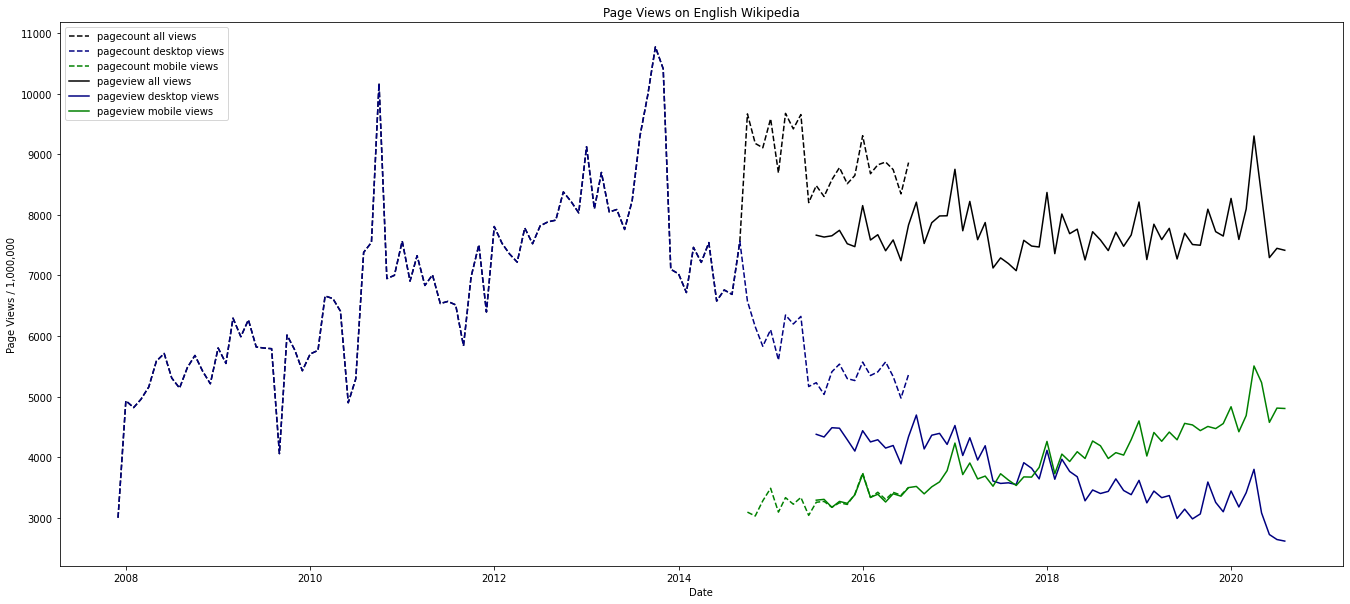

In [15]:
plt.figure(figsize=(23,10))
plt.plot(df.pagecount_all_views / 1000000, '--', color = 'black', label = 'pagecount all views')
plt.plot(df.pagecount_desktop_views / 1000000, '--', color = 'navy', label = 'pagecount desktop views')
plt.plot(df.pagecount_mobile_views / 1000000, '--', color = 'green', label = 'pagecount mobile views')
plt.plot(df.pageview_all_views / 1000000, color = 'black', label = 'pageview all views')
plt.plot(df.pageviews_desktop_views / 1000000, color = 'navy', label = 'pageview desktop views')
plt.plot(df.pageviews_mobile_views / 1000000, color = 'green', label = 'pageview mobile views')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Page Views / 1,000,000')
# plt.xlim((2008,2020))
plt.title('Page Views on English Wikipedia')
plt.savefig('Page Views on English Wikipedia.png')